# Model Training: Forwards - Linear Regression

The task here will be to train a model to predict that value of NHL players who play the Forward position. Choice of features is based on the EDA done in 01_F_EDA.ipynb (Folder 4_ExploratoryDataAnalysis)

## Import our data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures


In [2]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv' 
data = pd.read_csv(filepath)

## Features to try:

Recall that the EDA done revealed that we should try to use the following features:

1. TOI/GP
2. TOTAL POINTS - although we may want to split this up into TOTAL ASSISTS and GOALS instead
3. TOTAL ASSISTS - although we may want to split this up into FIRST ASSISTS and SECOND ASSISTS instead
4. XGF/60 - This may not make sense to use, since it is so closely tied to XGA, which is part of the intersection
5. ON THE FLY STARTS/60 - This is probably covered by TOI/GP which it has a -.75 correlation with
6. OFF. ZONE FACEOFFS/60 - May make sense to be integrated into the PCA as it is a bit of a nuanced statistic
7. TOTAL POINTS/60 - Is too closely linked to TOTAL POINTS. We should use one or the other.
8. SHOTS - I think this would be a good metric to try to include.
9. GOALS - I think it goes without saying that we should use Goals.
10. We may want to include 'LDGF', 'OFF. ZONE STARTS', 'LDCF', 'MDGF', 'OFF. ZONE FACEOFFS',
       'HDCF', 'CF', 'FF', 'SF', 'MDCF', 'SCF', 'XGF', 'ICF', 'HDGF', 'IFF',
       'ISCF', 'IXG', 'GF' as a PCA

In [23]:
# # THE FOLLOWING CELL UTILIZES MANUAL FEATURE SELECTION

# forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])].copy()

# # Select only forwards with 41 or more games played
# test_train_data = forwards[(forwards['GP'] >= 41)].copy()

# # Select the features we want to use as predictors
# # numerical_features = ['GOALS/60', 'TOTAL ASSISTS/60', 'FIRST ASSISTS/60', 'SHOTS/60', 'IXG/60', 'ISCF/60', 'IHDCF/60', 'RUSH ATTEMPTS/60', 'REBOUNDS CREATED/60', 'PIM/60', 'TOTAL PENALTIES/60', 'MISCONDUCT/60', 'PENALTIES DRAWN/60', 'GIVEAWAYS/60', 'TAKEAWAYS/60', 'HITS/60', 'HITS TAKEN/60', 'SHOTS BLOCKED/60', 'FACEOFFS WON/60', 'FACEOFFS LOST/60', 'CF/60', 'FF/60', 'SF/60', 'GF/60', 'GA/60', 'XGF/60', 'HDCF/60', 'HDCA/60', 'HDGA/60', 'MDGF/60', 'MDGA/60', 'LDCF/60', 'LDCA/60', 'LDGF/60', 'LDGA/60', 'OFF.\xa0ZONE STARTS/60', 'NEU.\xa0ZONE FACEOFFS/60', 'DEF.\xa0ZONE FACEOFFS/60', 'ON\xa0THE\xa0FLY STARTS', 'TOTAL ASSISTS/GP', 'FIRST ASSISTS/GP', 'SECOND ASSISTS/GP', 'TOTAL POINTS/GP', 'SHOTS/GP', 'IXG/GP', 'ISCF/GP', 'IHDCF/GP', 'REBOUNDS CREATED/GP', 'PIM/GP', 'MINOR/GP', 'MISCONDUCT/GP', 'PENALTIES DRAWN/GP', 'GIVEAWAYS/GP', 'HITS/GP', 'HITS TAKEN/GP', 'SHOTS BLOCKED/GP', 'FACEOFFS WON/GP', 'FACEOFFS LOST/GP', 'CA/GP', 'FA/GP', 'SA/GP', 'GF/GP', 'GA/GP', 'XGF/GP', 'XGA/GP', 'HDCF/GP', 'HDGA/GP', 'MDGF/GP', 'MDGA/GP', 'LDGF/GP', 'LDGA/GP', 'OFF.\xa0ZONE FACEOFFS/GP']

# selected_features = ['GOALS/GP', 'TOTAL ASSISTS/GP', 'TOTAL POINTS/GP'] + ['GOALS/60', 'TOTAL ASSISTS/60', 'TOTAL POINTS/60']

# # Define transformers
# numerical_transformer = Pipeline(steps = [
#     ('poly', PolynomialFeatures(degree=1)),
#     ('scaler', StandardScaler())
# ])

# preprocessor = ColumnTransformer(transformers=[
#     ('num', numerical_transformer, selected_features)
# ])

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', LinearRegression())
# ])

# X = test_train_data.drop('SALARY CAP PERCENTAGE', axis=1)
# y = test_train_data['SALARY CAP PERCENTAGE']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0005809068900252877


In [26]:
# THE FOLLOWING CELL UTILIZES SEQUENTIAL FEATURE SELECTION USING SequentialFeatureSelector from sklearn.feature_selection

forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])].copy()

# Select only players with 60 or more games played
test_train_data = forwards[(forwards['GP'] >= 41)]

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

# Define transformers for the numerical features
transformers = [
    ('num', StandardScaler(), numerical_features)
]

preprocessor = ColumnTransformer(transformers=transformers)

# Define a linear regression model
linear_regression_model = LinearRegression()

# Define the Sequential Feature Selector with the Linear Regression model
sfs = SequentialFeatureSelector(linear_regression_model, n_features_to_select=6, direction='forward', scoring='neg_mean_squared_error')

# Create a pipeline that includes the preprocessor, SFS, and the regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sfs', sfs),
    ('regressor', linear_regression_model)
])

# Split your data
X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Assuming your pipeline is named 'pipeline' and has been fitted
sfs = pipeline.named_steps['sfs']  # Access the fitted SFS object from the pipeline

# Get the boolean mask of selected features
selected_features_mask = sfs.get_support()

# Apply this mask to the feature names to get the list of selected features
selected_features = numerical_features[selected_features_mask]

print("Selected features:", list(selected_features))


Mean Squared Error: 0.0005224821964080394
Selected features: ['GIVEAWAYS/GP', 'HITS TAKEN/GP', 'TOTAL PENALTIES/60', 'OFF.\xa0ZONE STARTS/GP', 'OFF.\xa0ZONE FACEOFFS/GP', 'OFF.\xa0ZONE FACEOFFS/60']


In [27]:
coefficients = pipeline.named_steps['regressor'].coef_
coefficient_names = list(selected_features)

used_features = []

for name, coef in zip(coefficient_names, coefficients):
    print(f'{name}: {coef}')
    used_features.append(name)

GIVEAWAYS/GP: 0.0025618779779043523
HITS TAKEN/GP: -0.0037003201739588686
TOTAL PENALTIES/60: 0.003698122247773279
OFF. ZONE STARTS/GP: -0.0076674991177148955
OFF. ZONE FACEOFFS/GP: 0.04658179979428059
OFF. ZONE FACEOFFS/60: -0.018056684654425167


In [28]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [29]:
# Create a feature column for the predicted salary
forwards['PRED_SALARY_PERCENTAGE'] = pipeline.predict(forwards)

# Create a column for the actual predicted salary
forwards['PRED_AAV'] = forwards['PRED_SALARY_PERCENTAGE'] * forwards['SALARY CAP']
forwards['PRED_AAV'] = forwards['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
forwards['DIFF'] = forwards['PRED_AAV'] - forwards['AAV']

# Convert to dollars
forwards['PRED_AAV'] = convert_to_dollars(forwards, 'PRED_AAV')
forwards['AAV'] = convert_to_dollars(forwards, 'AAV')
forwards['DIFF'] = convert_to_dollars(forwards, 'DIFF')

In [30]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = forwards[forwards['GP'] > 21].sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(10)
display_features = ['PLAYER', 'SEASON'] + used_features + ['AAV', 'PRED_AAV', 'DIFF', 'SALARY CAP PERCENTAGE', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,GIVEAWAYS/GP,HITS TAKEN/GP,TOTAL PENALTIES/60,OFF. ZONE STARTS/GP,OFF. ZONE FACEOFFS/GP,OFF. ZONE FACEOFFS/60,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE
11910,nathan mackinnon,2023-24,1.0435,0.9275,0.49,6.4203,13.6957,35.92,"$12,600,000.00","$11,935,372.00","$-664,628.00",0.150898,0.142939
11896,mikko rantanen,2023-24,0.5217,1.6667,0.86,6.6232,13.6957,35.47,"$9,250,000.00","$11,004,218.00","$1,754,218.00",0.110778,0.131787
11152,nathan mackinnon,2022-23,0.6620,1.0282,0.57,5.2958,12.7465,34.27,"$6,300,000.00","$10,829,327.00","$4,529,327.00",0.076364,0.131265
11139,mikko rantanen,2022-23,0.5488,1.5854,1.09,5.8902,12.8537,34.70,"$9,250,000.00","$10,250,024.00","$1,000,024.00",0.112121,0.124243
3071,ilya kovalchuk,2012-13,1.1081,0.9459,0.59,5.0811,10.6486,25.83,"$6,666,666.00","$7,412,898.00","$746,232.00",0.111111,0.123548
7991,nathan mackinnon,2018-19,0.7805,1.1585,0.56,6.0976,12.5000,33.95,"$6,300,000.00","$9,741,934.00","$3,441,934.00",0.079245,0.122540
10342,nathan mackinnon,2021-22,0.8615,1.2615,0.79,5.4769,11.8769,33.84,"$6,300,000.00","$9,409,788.00","$3,109,788.00",0.077301,0.115458
424,alex ovechkin,2008-09,1.3544,1.9494,1.12,3.9114,10.1646,26.51,"$9,538,462.00","$6,519,879.00","$-3,018,583.00",0.168227,0.114989
9513,nathan mackinnon,2020-21,0.6042,1.0625,0.74,5.6458,12.2708,36.13,"$6,300,000.00","$9,265,871.00","$2,965,871.00",0.077301,0.113692
12055,sidney crosby,2023-24,0.7206,0.5441,0.71,5.5441,11.8088,35.46,"$8,700,000.00","$9,467,341.00","$767,341.00",0.104192,0.113381


In [31]:
# Display all seasons for Connor McDavid
connor_mcdavid = forwards[forwards['PLAYER'] == 'connor mcdavid']
connor_mcdavid[display_features]

,PLAYER,SEASON,GIVEAWAYS/GP,HITS TAKEN/GP,TOTAL PENALTIES/60,OFF. ZONE STARTS/GP,OFF. ZONE FACEOFFS/GP,OFF. ZONE FACEOFFS/60,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE
5276,connor mcdavid,2015-16,0.3778,1.0889,0.64,3.6889,7.9556,25.28,"$3,775,000.00","$5,070,921.00","$1,295,921.00",0.012955,0.071021
6071,connor mcdavid,2016-17,0.6585,1.4390,0.45,4.5610,8.6098,24.45,"$3,775,000.00","$5,856,761.00","$2,081,761.00",0.012671,0.080230
6841,connor mcdavid,2017-18,0.8171,1.4390,0.24,4.5000,9.0976,25.33,"$3,775,000.00","$6,626,940.00","$2,851,940.00",0.012333,0.088359
7617,connor mcdavid,2018-19,1.1410,1.3846,0.34,5.2179,10.0256,26.34,"$12,500,000.00","$8,257,358.00","$-4,242,642.00",0.157233,0.103866
8398,connor mcdavid,2019-20,1.1719,0.8906,0.60,4.7188,10.1562,27.87,"$12,500,000.00","$9,045,967.00","$-3,454,033.00",0.153374,0.110993
9143,connor mcdavid,2020-21,0.8393,1.5893,0.48,4.4286,10.9821,29.74,"$12,500,000.00","$9,148,251.00","$-3,351,749.00",0.153374,0.112248
9952,connor mcdavid,2021-22,0.8500,1.5500,0.54,4.0750,9.7500,26.51,"$12,500,000.00","$8,227,011.00","$-4,272,989.00",0.153374,0.100945
10786,connor mcdavid,2022-23,0.9390,1.3171,0.59,4.6098,10.2439,27.46,"$12,500,000.00","$8,901,924.00","$-3,598,076.00",0.151515,0.107902
11570,connor mcdavid,2023-24,1.0462,1.5385,0.64,4.8000,10.8308,30.12,"$12,500,000.00","$9,136,234.00","$-3,363,766.00",0.149701,0.109416


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Centers')

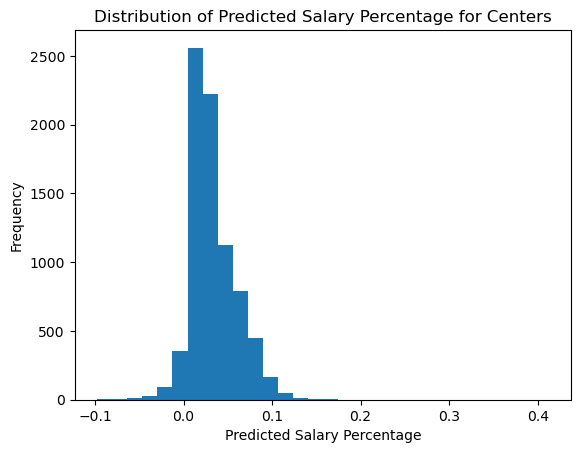

In [33]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(forwards[forwards['PRED_SALARY_PERCENTAGE'] > -0.1]['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Centers')

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for Forwards')

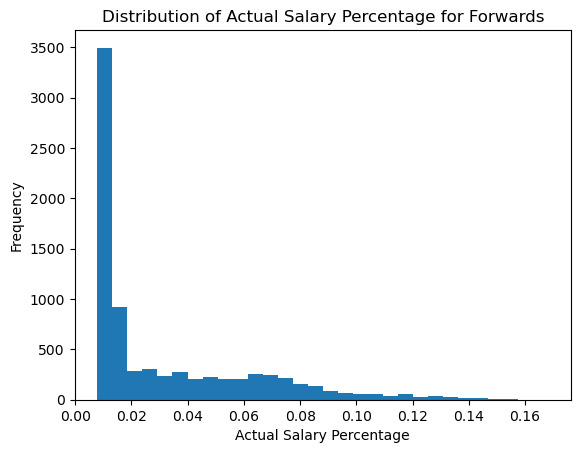

In [34]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(forwards['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for Forwards')

In [35]:
# Filter players with over 41 GP
filtered_data = forwards[(forwards['GP'] > 60) & (forwards['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,OFF. ZONE FACEOFFS/GP,XGF/GP,FF/GP,CF/GP,SF/GP,SCF/GP,MDCF/GP,...,OFF. ZONE FACEOFFS/60,TOTAL POINTS/60,GOALS/GP,GF/60,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE,Differential
11975,chi,philipp kurashev,2023-24,9.3492,1.0794,13.8254,19.4286,9.6190,9.7778,7.6825,...,29.45,2.20,0.2222,3.15,"$2,250,000.00","$6,667,937.00","$4,417,937.00",0.026946,0.079856,4417937.0
11754,col,jonathan drouin,2023-24,8.5000,1.1818,16.4091,22.4091,11.5606,11.1818,8.6061,...,29.16,2.13,0.1818,4.83,"$825,000.00","$4,542,204.00","$3,717,204.00",0.009880,0.054398,3717204.0
11635,s.j,fabian zetterlund,2023-24,7.2174,1.0000,13.0290,18.2754,8.7681,8.7391,6.9420,...,23.00,1.48,0.2609,3.19,"$1,450,000.00","$4,976,083.00","$3,526,083.00",0.017365,0.059594,3526083.0
11495,t.b,brandon hagel,2023-24,5.0290,1.1594,14.5652,20.2029,9.8696,10.2464,8.0000,...,15.52,2.82,0.3333,3.98,"$1,500,000.00","$5,011,437.00","$3,511,437.00",0.017964,0.060017,3511437.0
12128,s.j,william eklund,2023-24,7.0000,0.9851,12.9552,18.7463,8.6567,8.7164,6.5821,...,22.69,1.50,0.1642,2.61,"$1,713,333.00","$5,182,176.00","$3,468,843.00",0.010339,0.062062,3468843.0
11961,phi,owen tippett,2023-24,7.8182,0.9697,14.9545,20.1212,10.6818,8.9394,7.0758,...,28.40,2.53,0.3788,3.25,"$1,500,000.00","$4,647,972.00","$3,147,972.00",0.017964,0.055664,3147972.0
12045,"mtl, wpg",sean monahan,2023-24,7.6286,1.1143,14.2000,19.4857,9.9143,9.7286,7.4429,...,25.31,2.37,0.3000,4.17,"$2,000,000.00","$5,139,460.00","$3,139,460.00",0.023772,0.061550,3139460.0
11650,nsh,gustav nyquist,2023-24,8.4714,1.2143,15.8286,22.0429,11.1857,11.0857,8.7286,...,28.84,3.02,0.2714,4.38,"$3,185,000.00","$6,126,653.00","$2,941,653.00",0.038144,0.073373,2941653.0
12133,dal,wyatt johnston,2023-24,5.6143,0.9714,12.7429,18.3143,8.9143,9.0857,6.9143,...,19.84,2.68,0.3714,3.33,"$1,000,417.00","$3,886,269.00","$2,885,852.00",0.010709,0.046542,2885852.0
11734,min,joel eriksson ek,2023-24,9.2576,1.4697,18.0303,24.7273,12.8182,12.4697,9.5152,...,26.93,2.64,0.4394,4.63,"$5,250,000.00","$8,020,517.00","$2,770,517.00",0.062874,0.096054,2770517.0


In [36]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(10)

,TEAM,PLAYER,SEASON,OFF. ZONE FACEOFFS/GP,XGF/GP,FF/GP,CF/GP,SF/GP,SCF/GP,MDCF/GP,...,OFF. ZONE FACEOFFS/60,TOTAL POINTS/60,GOALS/GP,GF/60,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE,Differential
11460,"vgk, wsh",anthony mantha,2023-24,4.0952,0.7619,10.8095,15.1270,7.3651,6.5556,4.6508,...,17.29,2.35,0.3333,3.55,"$5,700,000.00","$2,060,546.00","$-3,639,454.00",0.068263,0.024677,-3639454.0
11505,mtl,brendan gallagher,2023-24,4.0781,0.7656,10.2969,14.7656,6.9531,7.1250,5.0000,...,17.62,1.35,0.1719,1.76,"$6,500,000.00","$2,764,388.00","$-3,735,612.00",0.077844,0.033106,-3735612.0
11473,tor,auston matthews,2023-24,9.6269,1.6269,20.1493,27.4776,13.6716,15.0448,10.9254,...,27.40,3.78,0.8507,5.31,"$11,640,250.00","$7,888,776.00","$-3,751,474.00",0.139404,0.094476,-3751474.0
11790,stl,kevin hayes,2023-24,4.2857,0.7000,9.8714,13.4714,7.0857,6.1714,4.9000,...,17.79,1.60,0.1857,2.55,"$7,142,857.00","$2,914,601.00","$-4,228,256.00",0.085543,0.034905,-4228256.0
11755,cgy,jonathan huberdeau,2023-24,9.1493,1.1493,15.2239,21.6269,10.4627,10.3731,8.3433,...,31.52,2.21,0.1343,3.29,"$10,500,000.00","$6,218,380.00","$-4,281,620.00",0.125749,0.074472,-4281620.0
11979,l.a,pierre-luc dubois,2023-24,6.5217,0.9565,13.5942,18.4058,9.0580,8.9710,7.3478,...,24.80,1.82,0.2174,2.76,"$8,500,000.00","$3,972,060.00","$-4,527,940.00",0.101796,0.047570,-4527940.0
11746,tor,john tavares,2023-24,8.7273,1.4697,17.4091,23.9697,12.3788,12.8485,9.3182,...,29.09,2.73,0.3485,4.39,"$11,000,000.00","$6,402,244.00","$-4,597,756.00",0.131737,0.076674,-4597756.0
11721,buf,jeff skinner,2023-24,8.2698,1.0476,15.3016,20.4921,10.7460,9.8095,8.4444,...,30.26,2.61,0.3810,4.01,"$9,000,000.00","$4,315,077.00","$-4,684,923.00",0.107784,0.051678,-4684923.0
11702,dal,jamie benn,2023-24,7.3286,1.0286,12.6714,18.1286,8.9143,9.2857,7.2143,...,29.29,2.63,0.1857,3.88,"$9,500,000.00","$4,075,018.00","$-5,424,982.00",0.113772,0.048803,-5424982.0
12012,col,ryan johansen,2023-24,4.9048,0.6825,10.0159,14.3016,7.1746,6.2698,4.9048,...,21.57,1.61,0.2063,2.79,"$8,000,000.00","$2,425,330.00","$-5,574,670.00",0.095808,0.029046,-5574670.0


In [37]:
filtered_data[filtered_data['PLAYER'] == 'warren foegele'][display_features]

,PLAYER,SEASON,OFF. ZONE FACEOFFS/GP,XGF/GP,FF/GP,CF/GP,SF/GP,SCF/GP,MDCF/GP,TOI/GP,...,SECOND ASSISTS/GP,OFF. ZONE FACEOFFS/60,TOTAL POINTS/60,GOALS/GP,GF/60,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE
12127,warren foegele,2023-24,4.2985,0.791,11.2239,15.0896,7.7313,7.8507,5.6567,13.837562,...,0.1045,18.64,2.27,0.2388,2.85,"$2,750,000.00","$1,976,829.00","$-773,171.00",0.032934,0.023675
